# Heart Disease Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report, RocCurveDisplay

In [2]:
# Read dataset
fn = 'Cardiovascular_Disease_Dataset.csv'
df = pd.read_csv(fn)
print('Loaded:', fn)
print('Shape:', df.shape)
df.head()


Loaded: Cardiovascular_Disease_Dataset.csv
Shape: (1000, 14)


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
0,103368,53,1,2,171,0,0,1,147,0,5.3,3,3,1
1,119250,40,1,0,94,229,0,1,115,0,3.7,1,1,0
2,119372,49,1,2,133,142,0,0,202,1,5.0,1,0,0
3,132514,43,1,0,138,295,1,1,153,0,3.2,2,2,1
4,146211,31,1,1,199,0,0,2,136,0,5.3,3,2,1


In [3]:
print('\n--- info() ---')
print(df.info())
print('\n--- describe() ---')
display(df.describe())
print('\n--- Missing values ---')
display(df.isnull().sum())



--- info() ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientid          1000 non-null   int64  
 1   age                1000 non-null   int64  
 2   gender             1000 non-null   int64  
 3   chestpain          1000 non-null   int64  
 4   restingBP          1000 non-null   int64  
 5   serumcholestrol    1000 non-null   int64  
 6   fastingbloodsugar  1000 non-null   int64  
 7   restingrelectro    1000 non-null   int64  
 8   maxheartrate       1000 non-null   int64  
 9   exerciseangia      1000 non-null   int64  
 10  oldpeak            1000 non-null   float64
 11  slope              1000 non-null   int64  
 12  noofmajorvessels   1000 non-null   int64  
 13  target             1000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 109.5 KB
None

--- describe() ---


,patientid,age,gender,chestpain,restingBP,serumcholestrol,fastingbloodsugar,restingrelectro,maxheartrate,exerciseangia,oldpeak,slope,noofmajorvessels,target
count,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,5.048704e+06,49.24200,0.765000,0.980000,151.747000,311.447000,0.296000,0.748000,145.477000,0.498000,2.707700,1.540000,1.222000,0.580000
std,2.895905e+06,17.86473,0.424211,0.953157,29.965228,132.443801,0.456719,0.770123,34.190268,0.500246,1.720753,1.003697,0.977585,0.493805
min,1.033680e+05,20.00000,0.000000,0.000000,94.000000,0.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.536440e+06,34.00000,1.000000,0.000000,129.000000,235.750000,0.000000,0.000000,119.750000,0.000000,1.300000,1.000000,0.000000,0.000000
50%,4.952508e+06,49.00000,1.000000,1.000000,147.000000,318.000000,0.000000,1.000000,146.000000,0.000000,2.400000,2.000000,1.000000,1.000000
75%,7.681877e+06,64.25000,1.000000,2.000000,181.000000,404.250000,1.000000,1.000000,175.000000,1.000000,4.100000,2.000000,2.000000,1.000000
max,9.990855e+06,80.00000,1.000000,3.000000,200.000000,602.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000



--- Missing values ---


patientid            0
age                  0
gender               0
chestpain            0
restingBP            0
serumcholestrol      0
fastingbloodsugar    0
restingrelectro      0
maxheartrate         0
exerciseangia        0
oldpeak              0
slope                0
noofmajorvessels     0
target               0
dtype: int64

Chosen target column: target


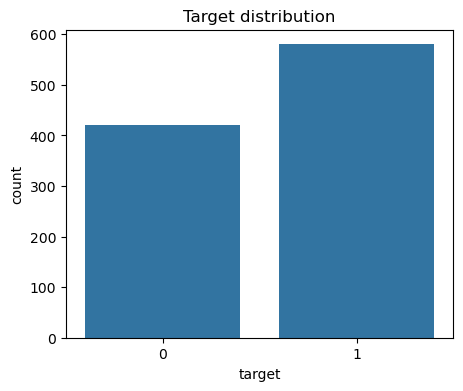

In [4]:
# Target distribution (bar chart)
possible_targets = [c for c in df.columns if c.lower() in ('cardio','target','disease','has_cvd')]
target_col = possible_targets[0] if possible_targets else df.columns[-1]  # fallback to last column if none found
print('Chosen target column:', target_col)
plt.figure(figsize=(5,4))
sns.countplot(x=df[target_col])
plt.title('Target distribution')
plt.show()


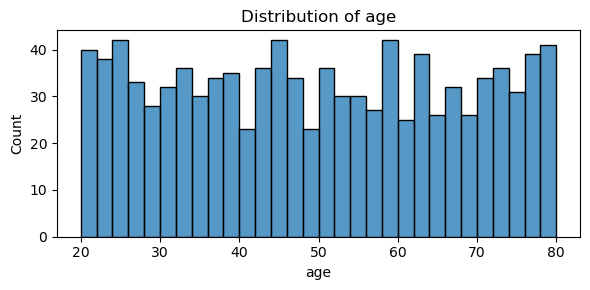

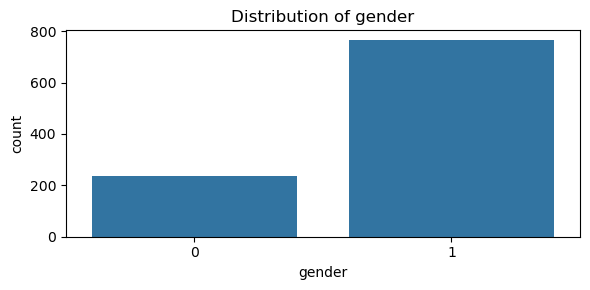

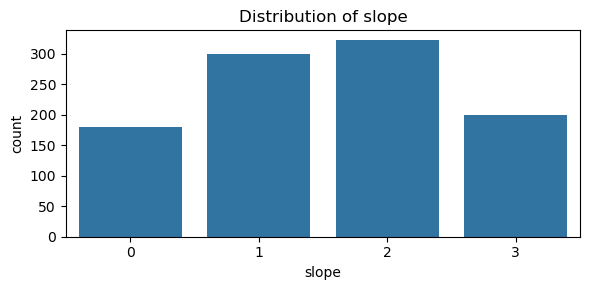

In [5]:
# Distribution plots for many columns
cols_to_plot = []
# trying to pick common columns by name (your dataset may have similar names)
for name in ['age','gender','cholesterol','gluc','smoke','alco','active','ap_hi','ap_lo','bmi','exercise','slope','fasting_blood_sugar','sex']:
    if name in df.columns and name not in cols_to_plot:
        cols_to_plot.append(name)

# show up to 8 distributions
for i, c in enumerate(cols_to_plot[:8]):
    plt.figure(figsize=(6,3))
    if df[c].nunique() <= 10:
        sns.countplot(x=df[c])
    else:
        sns.histplot(df[c].dropna(), kde=False, bins=30)
    plt.title(f'Distribution of {c}')
    plt.tight_layout()
    plt.show()


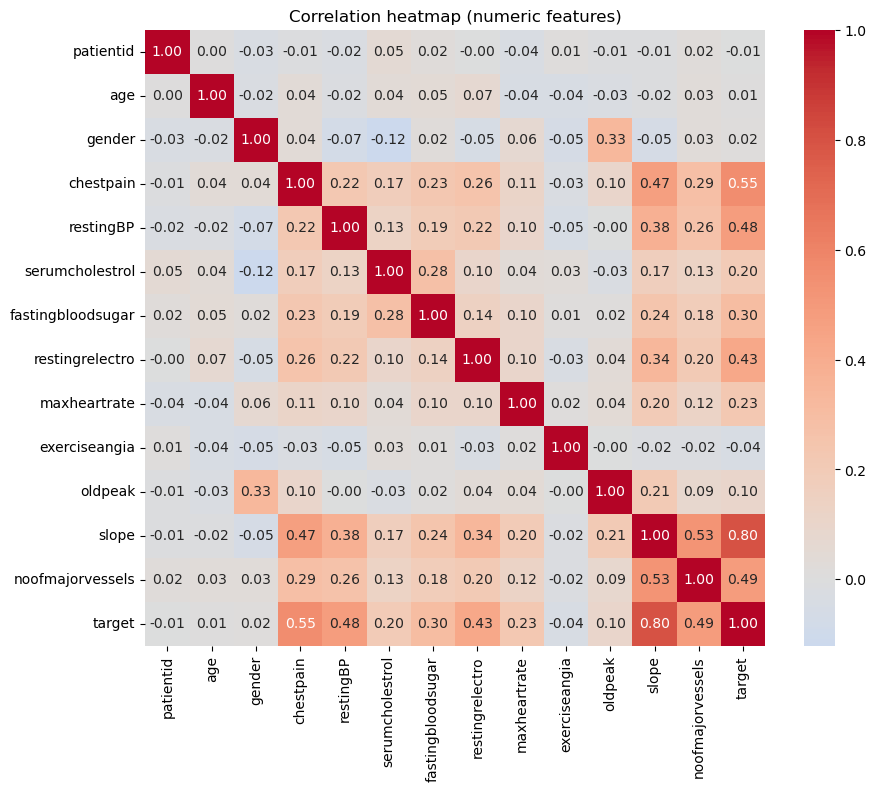

In [6]:
# Correlation heatmap
plt.figure(figsize=(10,8))
num_df = df.select_dtypes(include=[np.number])
corr = num_df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation heatmap (numeric features)')
plt.show()


In [7]:
data = df.copy()

# If age is in days, convert to years if values look large
if 'age' in data.columns:
    if data['age'].median() > 200:
        data['age'] = (data['age'] / 365).round().astype(int)

# Create bmi if not present but height & weight available (common in some cardio datasets)
if 'bmi' not in data.columns and set(['height','weight']).issubset(data.columns):
    data['height_m'] = data['height'] / 100.0
    data['bmi'] = data['weight'] / (data['height_m']**2)

# Fill missing numeric values with median (simple)
for c in data.select_dtypes(include=[np.number]).columns:
    if data[c].isnull().sum() > 0:
        data[c] = data[c].fillna(data[c].median())

# Map known categorical columns if present (student mappings)
if 'gender' in data.columns and set(data['gender'].unique()) - set([0,1]):
    # try common mapping
    data['gender'] = data['gender'].map({1:'M',2:'F',0:np.nan}).map({'M':1,'F':0})

# If 'sex' exists convert male/female to 0/1
if 'sex' in data.columns and data['sex'].dtype == object:
    data['sex'] = data['sex'].map(lambda x: 1 if str(x).lower() in ['male','m'] else 0)

# Choose features: drop target_col and any id column
X = data.drop(columns=[target_col] if target_col in data.columns else [data.columns[-1]])
# drop id like columns
for c in X.columns:
    if 'id' in c.lower() or c.lower().startswith('patient'):
        X = X.drop(columns=[c])
y = data[target_col].astype(int) if target_col in data.columns else data.iloc[:, -1].astype(int)
print('Features used:', X.columns.tolist())


Features used: ['age', 'gender', 'chestpain', 'restingBP', 'serumcholestrol', 'fastingbloodsugar', 'restingrelectro', 'maxheartrate', 'exerciseangia', 'oldpeak', 'slope', 'noofmajorvessels']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('train/test shapes:', X_train.shape, X_test.shape)


train/test shapes: (800, 12) (200, 12)


In [9]:
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc = pd.get_dummies(X_test, drop_first=True)

X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)
print('Encoded train/test shapes:', X_train_enc.shape, X_test_enc.shape)


Encoded train/test shapes: (800, 12) (200, 12)


In [10]:
# Logistic Regression with GridSearchCV
lr = LogisticRegression(max_iter=1000, solver='liblinear')

param_grid = {'C':[0.01,0.1,1,10], 'penalty':['l2']}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=7)
gs_lr = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
gs_lr.fit(X_train_enc, y_train)
print('Best LR params:', gs_lr.best_params_)
print('Best LR CV ROC_AUC:', round(gs_lr.best_score_,4))


Best LR params: {'C': 10, 'penalty': 'l2'}
Best LR CV ROC_AUC: 0.9908


In [11]:
# Decision Tree with GridSearchCV (basic grid)
dt = DecisionTreeClassifier(random_state=7)
param_dt = {'max_depth':[3,5,8,None], 'min_samples_leaf':[1,3,5]}
gs_dt = GridSearchCV(dt, param_dt, scoring='roc_auc', cv=cv, n_jobs=-1)
gs_dt.fit(X_train_enc, y_train)
print('Best DT params:', gs_dt.best_params_)
print('Best DT CV ROC_AUC:', round(gs_dt.best_score_,4))


Best DT params: {'max_depth': 5, 'min_samples_leaf': 5}
Best DT CV ROC_AUC: 0.9747



=== LogisticRegression ===
Accuracy: 0.98
F1 score: 0.983
ROC AUC: 0.998
Confusion Matrix:
[[ 81   3]
 [  1 115]]


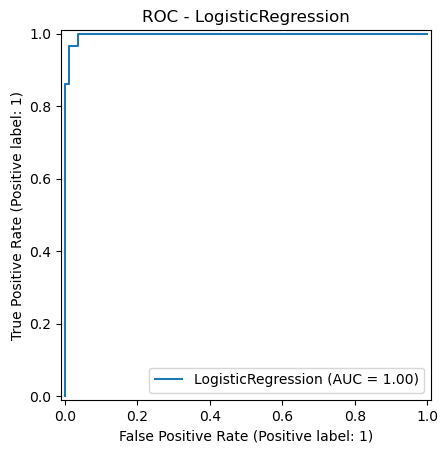


=== DecisionTree ===
Accuracy: 0.97
F1 score: 0.975
ROC AUC: 0.982
Confusion Matrix:
[[ 79   5]
 [  1 115]]


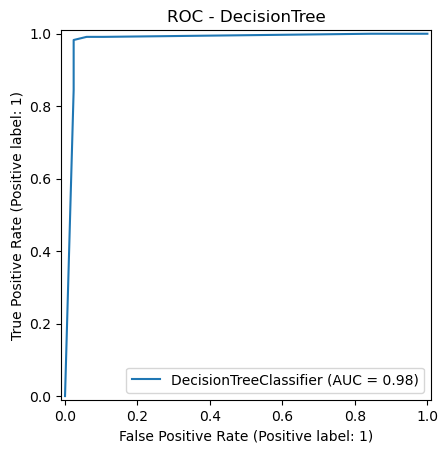

In [12]:
# Evaluate both models on test set (accuracy, f1, roc_auc) and show confusion matrices
models = {'LogisticRegression': gs_lr.best_estimator_, 'DecisionTree': gs_dt.best_estimator_}

for name, model in models.items():
    preds = model.predict(X_test_enc)
    probs = model.predict_proba(X_test_enc)[:,1] if hasattr(model,'predict_proba') else model.decision_function(X_test_enc)
    print('\n===', name, '===')
    print('Accuracy:', round(accuracy_score(y_test, preds),3))
    print('F1 score:', round(f1_score(y_test, preds),3))
    try:
        print('ROC AUC:', round(roc_auc_score(y_test, probs),3))
    except Exception as e:
        print('ROC AUC error:', e)
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, preds))
    # plot ROC curve
    RocCurveDisplay.from_estimator(model, X_test_enc, y_test)
    plt.title('ROC - '+name)
    plt.show()



## Short Conclusion

- Two models were trained: **Logistic Regression** and **Decision Tree** using GridSearchCV for simple hyperparameter tuning.  
- Basic preprocessing was used (median fill, simple encoding).  
- Compare accuracy, F1 and ROC AUC to decide which model works better for this dataset.  
- This notebook follows a student-style approach as requested.
